In [17]:
# import all libraries required 
import pandas as pd 
import numpy as np 
import os
import re
import string

#String manipulations
import re, string
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [15]:
!pip install gensim

In [2]:
# Read the data from both the csv and get only the job description from both of those. 

import pandas as pd
import os

# Define the folder path where the CSV files are stored
folder_path = './data'

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to store data frames
dfs = []

# Iterate over the CSV files and read them into data frames
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    # Assume the column with job descriptions is named 'JobDescription'
    if 'Job Description' in df.columns:
        dfs.append(df[['Job Description']])
    else:
        print(f"Column 'Job Description' not found in {file}")

# Concatenate all data frames into a single data frame
all_job_descriptions = pd.concat(dfs, ignore_index=True)

# Display the combined data frame
print(all_job_descriptions.head())
print(all_job_descriptions.info())


                                     Job Description
0  Booking.com\r\nIt wasn’t so long ago that book...
1  At Booking.com, data drives our decisions. Tec...
2  Booking.com’s global treasury team is looking ...
3  About the company\r\nIt wasn’t so long ago tha...
4  Account Executive - Bristol\r\nThis is a full ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Description  1311 non-null   object
dtypes: object(1)
memory usage: 10.4+ KB
None


In [91]:
all_job_descriptions['Job Description'].iloc[2]

'Booking.com’s global treasury team is looking for a  Treasury risk management professional to join our growing team. \r The Treasury Risk Specialist is responsible for performing financial analysis and operating processes relating to the identification, quantification, management and reporting of credit, counterparty, liquidity and other Treasury risk typologies that attach to Booking’s evolving business models, strategic initiatives and third party relationships.  \r The individual will form an integral part of the Treasury Risk Team, reporting to the Treasury Manager for this function.  \r The preferred candidate should be accustomed to working in a fast paced environment while working collaboratively across various internal functional teams.\r The candidate should be able to demonstrate a proven ability to perform risk analysis and reporting and drive operational efficiencies through the design and implementation of End to End processes leveraging and adopting new technologies to s

In [3]:
# Check for duplicate values in the 'JobDescription' column
duplicate_mask = all_job_descriptions['Job Description'].duplicated()

# Count the number of duplicates
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate job descriptions: {num_duplicates}")

Number of duplicate job descriptions: 608


In [4]:
# Display the duplicate rows
duplicate_rows = all_job_descriptions[duplicate_mask]
print("Duplicate job descriptions:")
print(duplicate_rows)

Duplicate job descriptions:
                                        Job Description
10    Our brand new FinTech business unit – with tea...
11    Booking.com is looking for data savvy professi...
94    Customer Sales Advisor – German Speaker\r\nBoo...
135   We’re looking for a strong collaborator who ca...
240   Booking.com is the largest  online travel agen...
...                                                 ...
1304  It wasn’t so long ago that booking a trip so s...
1305  Senior Front End Developer\r\nWho are we?\r\nA...
1306  At Booking.com, we make it easier for everyone...
1307  Senior Java Developer\r\n  Who are we? \r\nAt ...
1308  At Booking.com, data drives our decisions. Tec...

[608 rows x 1 columns]


In [5]:
all_job_descriptions['Job Description'] = all_job_descriptions['Job Description'].apply(lambda x : re.sub('\\\n',' ', x)) #Replace all newlines
all_job_descriptions['R_word_count'] = all_job_descriptions['Job Description'].apply(lambda x : len(x.split())) #Splitting strin into words
all_job_descriptions['R_char_count'] = all_job_descriptions['Job Description'].apply(lambda x : len(x.replace(' ',''))) #Removing spaces and counting characters


In [6]:
all_job_descriptions['R_word_density'] = all_job_descriptions['R_word_count'] / (all_job_descriptions['R_char_count'] + 1) #Devide total words by number of characters
all_job_descriptions['R_punc_count'] = all_job_descriptions['Job Description'].apply(lambda x : len([a for a in x if a in string.punctuation])) #Count punctuation by comparing to string.punctuation

df_stats_raw = all_job_descriptions[['Job Description','R_word_count', 'R_char_count', 'R_word_density', 'R_punc_count']]

In [7]:
all_job_descriptions.head()

,Job Description,R_word_count,R_char_count,R_word_density,R_punc_count
0,Booking.com\r It wasn’t so long ago that booki...,962,5781,0.166378,161
1,"At Booking.com, data drives our decisions. Tec...",687,3788,0.181314,77
2,Booking.com’s global treasury team is looking ...,833,5243,0.158848,106
3,About the company\r It wasn’t so long ago that...,1155,6597,0.175053,116
4,Account Executive - Bristol\r This is a full t...,549,2959,0.185473,53


In [8]:
def get_pos_func(word):
    '''
    Maps the respective POS tag of a word to the format accepted by the Wordnet lemmatizer
    
    Args:
        word (str): Word to which the function is to be applied
    
    Returns:
        POS tag, readable for the Wordnet lemmatizer
    '''     
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
def clean_string_func(text, x):
    '''
    Create cleaned text or list of words
    
    Step 1: Use word_tokenize() to get tokens from lowered string
    Step 2: Use WordNetLemmatizer() to lemmatize the created tokens
            POS tag is determined with the help of function get_wordnet_pos()
    Step 3: Remove stopwords by iterating through tokens
    Step 4: Remove single characters by iterating through tokens
    Step 5: Remove punctuation by iterating through tokens
    Step 6: Join words to create text
    
    Args:
        text (str): String to which the functions are to be applied, string
        x (str): Letter that denotes return type ('w' = words, otherwise text)
    
    Returns:
        List of lemmatize words
        String with lemmatized words
    ''' 
    words = word_tokenize(text.lower()) #Create tokens from text and transform to lowercase
    words = [WordNetLemmatizer().lemmatize(word, get_pos_func(word)) for word in words] #Lemmatize words through appropriate POS from get_pos_func
    words = [wrd for wrd in words if wrd not in stopwords.words('english')] #Remove all words that appear in stopword list
    words = [wrd for wrd in words if len(wrd) > 1 and len(wrd) != 'r'] #Remove single character words that's not programming language R
    words = [wrd for wrd in words if wrd not in string.punctuation] #Remove punctuation
    text = ' '.join(words) #Join words to create text

    if x == 'w':
        return words
    return text

In [10]:
all_job_descriptions['Job Description - Cleaned'] = all_job_descriptions['Job Description'].apply(lambda x : clean_string_func(x,'t')) #Create new column of cleaned job descriptions

In [11]:
all_job_descriptions['Job Description - Cleaned'].head()

0    booking.com long ago book trip see eiffel towe...
1    booking.com data drive decision technology cor...
2    booking.com global treasury team look treasury...
3    company long ago book trip see eiffel tower st...
4    account executive bristol full time position b...
Name: Job Description - Cleaned, dtype: object

In [19]:
# Create embeddigs from the job Description -cleaned column. 
# Prepare data for Doc2Vec
tagged_data = [TaggedDocument(words=row.split(), tags=[str(i)]) for i, row in 
               enumerate(all_job_descriptions['Job Description - Cleaned'])]

# Train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=200, # You can adjust the size
                        window=5,
                        min_count=2,
                        workers=4,
                        epochs=40)

# Build vocabulary
doc2vec_model.build_vocab(tagged_data)

# Train the model
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Save the trained model
doc2vec_model.save("doc2vec_model")

print("Doc2Vec model trained and saved.")

Doc2Vec model trained and saved.


In [20]:
# Load the trained model (if not already loaded)
doc2vec_model = Doc2Vec.load("doc2vec_model")

# Create embeddings for each job description
all_job_descriptions['Embeddings'] = all_job_descriptions['Job Description - Cleaned'].apply(lambda x: doc2vec_model.infer_vector(x.split()))

# Save the dataframe with embeddings
all_job_descriptions.to_csv('job_descriptions_with_embeddings.csv', index=False)

print("Embeddings created and saved.")

Embeddings created and saved.


In [24]:
!pip install scikit-learn


In [32]:
!pip install --upgrade --force-reinstall gap-stat

  Using cached https://files.pythonhosted.org/packages/97/9f/da37cc4a188a1d5d203d65ab28d6504e17594b5342e0c1dc5610ee6f4535/numpy-1.21.6-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b2/56/f886ed6f1777ffa9d54c6e80231b69db8a1f52dcc33f5967b06a105dcfe0/pandas-1.3.5-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/40/69/4af412d078cef2298f7d90546fa0e03e65a032558bd85319239c72ae0c3c/scipy-1.7.3-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9c/3d/a121f284241f08268b21359bd425f7d4825cffc5ac5cd0e1b3d82ffd2b10/pytz-2024.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
  Found existing installation: numpy 1.20

ERROR: tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.0.0 has requirement tensorboard<2.1.0,>=2.0.0, but you'll have tensorboard 2.2.2 which is incompatible.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.16.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\anant\\anaconda3\\lib\\site-packages\\~umpy\\.libs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [36]:
from sklearn.cluster import KMeans
import numpy as np

def compute_gap_statistic(data, max_k):
    # Compute reference distribution for gap statistic
    reference_distributions = []
    for _ in range(10):  # Number of reference datasets to generate
        reference_data = np.random.random_sample(data.shape)
        kmeans = KMeans(n_clusters=max_k)
        kmeans.fit(reference_data)
        reference_distributions.append(kmeans.inertia_)

    # Compute gap statistic for each value of k
    gap_values = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        log_wk = np.log(kmeans.inertia_)
        reference_log_wks = np.mean(np.log(reference_distributions))
        gap = reference_log_wks - log_wk
        gap_values.append(gap)

    # Find optimal k
    optimal_k = np.argmax(gap_values) + 1  # Add 1 because range starts from 1
    return gap_values, optimal_k

 # Assuming embeddings is your data matrix (list of embeddings)
# Convert the embeddings column to a NumPy array
embeddings = np.array(all_job_descriptions['Embeddings'].tolist())
max_k = 40 # Maximum number of clusters to consider
gap_values, optimal_k = compute_gap_statistic(embeddings, max_k)

print(f"Gap statistic values: {gap_values}")
print(f"Optimal number of clusters (k): {optimal_k}")


Gap statistic values: [-1.7986297030378164, -1.7590488050688524, -1.7377536202656287, -1.7249704549168303, -1.7186003664849796, -1.692191663098173, -1.6806251278755173, -1.6748974970487591, -1.6692429460342328, -1.6625253514622393, -1.6546086931762822, -1.6381391967844845, -1.6368568323143755, -1.6311137108394558, -1.6321043416245207, -1.6197386267388083, -1.5994418012198945, -1.602250948412303, -1.6009167371744635, -1.5905015102834401, -1.581623371755974, -1.569063745079454, -1.5623447996832098, -1.5659125136887706, -1.5366021075278535, -1.5444393360342517, -1.5469278039273373, -1.5291228155063266, -1.541580641068764, -1.5282891154588043, -1.5144606450246343, -1.5129205113118491, -1.5099524955726853, -1.4933893902361142, -1.4954847752803726, -1.4875659884372041, -1.4896320370010105, -1.4839552525242254, -1.474847276002956, -1.46676287513837]
Optimal number of clusters (k): 40


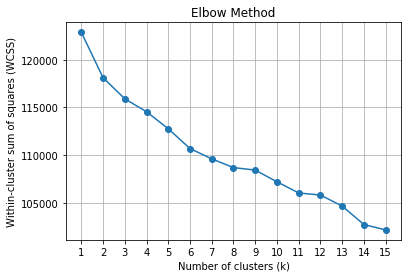

Optimal number of clusters (k): 2


In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k(data, max_k):
    wcss = []  # Within-cluster sum of squares

    # Calculate WCSS for different values of k
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method graph
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster sum of squares (WCSS)')
    plt.title('Elbow Method')
    plt.xticks(np.arange(1, max_k + 1))
    plt.grid(True)
    plt.show()

    # Find the optimal k (Elbow point)
    diff_wcss = np.diff(wcss, 2)
    optimal_k = np.argmax(diff_wcss) + 2  # Add 2 to account for zero-based indexing and diff operation
    return optimal_k

# Example usage

max_k = 15  # Maximum number of clusters to consider
optimal_k = find_optimal_k(embeddings, max_k)
print(f"Optimal number of clusters (k): {optimal_k}")


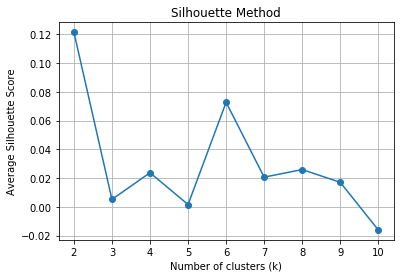

Optimal number of clusters (k): 2


In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k_silhouette(data, max_k):
    silhouette_scores = []

    # Calculate silhouette score for different values of k
    for k in range(2, max_k + 1):  # Silhouette score requires at least 2 clusters
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the Silhouette Method graph
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Method')
    plt.xticks(np.arange(2, max_k + 1))
    plt.grid(True)
    plt.show()

    # Find the optimal k (maximum silhouette score)
    optimal_k = np.argmax(silhouette_scores) + 2  # Add 2 to account for starting from 2 clusters
    return optimal_k


max_k = 10  # Maximum number of clusters to consider
optimal_k = find_optimal_k_silhouette(embeddings, max_k)
print(f"Optimal number of clusters (k): {optimal_k}")


In [41]:
!pip install hdbscan

  Using cached https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl
  Found existing installation: joblib 0.13.2
    Uninstalling joblib-0.13.2:
      Successfully uninstalled joblib-0.13.2


Optimal number of clusters (k): 31


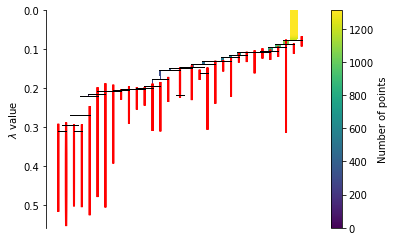

In [42]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_k_hdbscan(data, min_cluster_size=5):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusterer.fit(data)
    cluster_labels = clusterer.labels_

    # Plot the cluster hierarchy
    clusterer.condensed_tree_.plot(select_clusters=True)

    # Extract the number of clusters
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters) - 1 if -1 in unique_clusters else len(unique_clusters)

    return num_clusters

# Example usage

optimal_k = find_optimal_k_hdbscan(embeddings)
print(f"Optimal number of clusters (k): {optimal_k}")
plt.show()


In [45]:
!pip install torch

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

# Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.ReLU(True),
            nn.Linear(500, 500),
            nn.ReLU(True),
            nn.Linear(500, latent_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define DEC Model
class DEC(nn.Module):
    def __init__(self, autoencoder, num_clusters, latent_dim):
        super(DEC, self).__init__()
        self.encoder = autoencoder.encoder
        self.cluster_layer = nn.Linear(latent_dim, num_clusters)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        encoded = self.encoder(x)
        cluster_probs = self.softmax(self.cluster_layer(encoded))
        return cluster_probs

# Pre-train Autoencoder
def pretrain_autoencoder(autoencoder, data, criterion, optimizer, num_epochs):
    autoencoder.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Initialize Cluster Centers
def initialize_cluster_centers(encoder, data, num_clusters):
    encoder.eval()
    encoded_data = encoder(data)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(encoded_data.detach().numpy())
    initial_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    return initial_centers

# Train DEC Model
def train_dec(dec_model, data, criterion, optimizer, initial_centers, num_epochs):
    dec_model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        cluster_probs = dec_model(data)
        loss = criterion(cluster_probs, initial_centers)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Predict Cluster Assignments
def predict_clusters(dec_model, encoder, data):
    dec_model.eval()
    with torch.no_grad():
        encoded_data = encoder(data)
        cluster_probs = dec_model(encoded_data)
        cluster_preds = torch.argmax(cluster_probs, dim=1)
    return cluster_preds.numpy()


# Convert data to PyTorch tensors
data = torch.tensor(embeddings, dtype=torch.float32)

# Define model parameters
latent_dim = data.shape[1]  # Dimension of embeddings
num_clusters = 31  # Number of clusters
num_epochs_autoencoder = 10
num_epochs_dec = 10
learning_rate = 0.001

# Instantiate autoencoder and DEC model
autoencoder = Autoencoder(latent_dim)
dec_model = DEC(autoencoder, num_clusters, latent_dim)

# Define loss function and optimizer
criterion_autoencoder = nn.MSELoss()
optimizer_autoencoder = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion_dec = nn.KLDivLoss(reduction='batchmean')
optimizer_dec = optim.Adam(dec_model.parameters(), lr=learning_rate)

# Pre-train autoencoder
pretrain_autoencoder(autoencoder, data, criterion_autoencoder, optimizer_autoencoder, num_epochs_autoencoder)

# Initialize cluster centers
initial_centers = initialize_cluster_centers(autoencoder.encoder, data, num_clusters)

# Train DEC model
train_dec(dec_model, data, criterion_dec, optimizer_dec, initial_centers, num_epochs_dec)

# Predict cluster assignments
cluster_predictions = predict_clusters(dec_model, autoencoder.encoder, data)




Epoch 1/10, Loss: 0.6514
Epoch 2/10, Loss: 0.6326
Epoch 3/10, Loss: 0.5905
Epoch 4/10, Loss: 0.5217
Epoch 5/10, Loss: 0.6397
Epoch 6/10, Loss: 0.4900
Epoch 7/10, Loss: 0.4935
Epoch 8/10, Loss: 0.5157
Epoch 9/10, Loss: 0.5262
Epoch 10/10, Loss: 0.5251


RuntimeError: The size of tensor a (200) must match the size of tensor b (31) at non-singleton dimension 1

In [51]:
import hdbscan


# Fit HDBSCAN clustering algorithm
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(list(all_job_descriptions['Embeddings']))

# Add cluster labels to DataFrame
all_job_descriptions['Cluster_Labels'] = cluster_labels

print(all_job_descriptions.head())


                                     Job Description  R_word_count  \
0  Booking.com\r It wasn’t so long ago that booki...           962   
1  At Booking.com, data drives our decisions. Tec...           687   
2  Booking.com’s global treasury team is looking ...           833   
3  About the company\r It wasn’t so long ago that...          1155   
4  Account Executive - Bristol\r This is a full t...           549   

   R_char_count  R_word_density  R_punc_count  \
0          5781        0.166378           161   
1          3788        0.181314            77   
2          5243        0.158848           106   
3          6597        0.175053           116   
4          2959        0.185473            53   

                           Job Description - Cleaned  \
0  booking.com long ago book trip see eiffel towe...   
1  booking.com data drive decision technology cor...   
2  booking.com global treasury team look treasury...   
3  company long ago book trip see eiffel tower st...   
4  a

In [52]:
all_job_descriptions['Cluster_Labels'].value_counts()


-1     955
 30     64
 15     26
 14     19
 27     18
 18     18
 29     13
 21     12
 4      10
 20     10
 19     10
 9      10
 24     10
 17      9
 22      9
 11      9
 26      8
 1       8
 25      8
 28      8
 23      8
 8       7
 6       7
 3       7
 16      6
 13      6
 12      6
 10      6
 7       6
 5       6
 2       6
 0       6
Name: Cluster_Labels, dtype: int64

In [62]:
all_job_descriptions.head()

,Job Description,R_word_count,R_char_count,R_word_density,R_punc_count,Job Description - Cleaned,Embeddings,Cluster_Labels
0,Booking.com\r It wasn’t so long ago that booki...,962,5781,0.166378,161,booking.com long ago book trip see eiffel towe...,"[-0.31907162, -1.0946442, -1.1768286, 0.832329...",-1
1,"At Booking.com, data drives our decisions. Tec...",687,3788,0.181314,77,booking.com data drive decision technology cor...,"[0.3812197, 0.23948741, 0.10944364, 0.07269724...",-1
2,Booking.com’s global treasury team is looking ...,833,5243,0.158848,106,booking.com global treasury team look treasury...,"[0.06302524, 0.6085494, -0.30382383, 0.4328197...",-1
3,About the company\r It wasn’t so long ago that...,1155,6597,0.175053,116,company long ago book trip see eiffel tower st...,"[-1.0455714, -0.017056238, -1.1916978, 0.08443...",-1
4,Account Executive - Bristol\r This is a full t...,549,2959,0.185473,53,account executive bristol full time position b...,"[0.058723077, 0.35270283, -0.7350738, 0.734504...",27


In [64]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd


# Define function to perform topic modeling on each cluster
def extract_topics_per_cluster(df, cluster_column, text_column, n_topics=3, top_n_words=5):
    topics_per_cluster = {}
    for cluster_label in df[cluster_column].unique():
        # Filter data for current cluster
        cluster_data = df[df[cluster_column] == cluster_label]
        
        # Extract text data for the current cluster
        text_data = cluster_data[text_column].tolist()
        
        # Create a CountVectorizer to convert text data to a matrix of token counts
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(text_data)
        
        # Perform Latent Dirichlet Allocation
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
        
        # Get top words for each topic
        feature_names = vectorizer.get_feature_names()
        top_words = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-top_n_words - 1:-1]
            top_words.append([feature_names[i] for i in top_words_idx])
        
        topics_per_cluster[cluster_label] = top_words
    
    return topics_per_cluster

# Extract topics per cluster
topics_per_cluster = extract_topics_per_cluster(all_job_descriptions, 'Cluster_Labels', 'Job Description - Cleaned')

# Print top topics for each cluster
for cluster_label, topics in topics_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    for idx, topic_words in enumerate(topics):
        print(f"Topic {idx + 1}: {', '.join(topic_words)}")
    print()

Cluster -1:
Topic 1: team, product, experience, work, data
Topic 2: work, experience, product, booking, com
Topic 3: team, business, experience, work, partner

Cluster 27:
Topic 1: lisbon, inspire, lyon, fluent, france
Topic 2: lisbon, inspire, lyon, fluent, france
Topic 3: partner, booking, com, business, responsible

Cluster 30:
Topic 1: angeles, meet, state, los, know
Topic 2: russia, duration, russian, llc, temporary
Topic 3: partner, com, booking, world, business

Cluster 24:
Topic 1: customer, help, love, work, travel
Topic 2: italian, spanish, german, write, fast
Topic 3: italian, spanish, german, write, fast

Cluster 16:
Topic 1: work, experience, world, booking, com
Topic 2: plus, provider, big, aws, available
Topic 3: plus, provider, big, aws, available

Cluster 18:
Topic 1: korean, romanian, freelance, newsletter, copy
Topic 2: language, quality, provide, experience, website
Topic 3: language, strong, quality, travel, provide

Cluster 17:
Topic 1: permit, shanghai, mandarin,

In [66]:
# Define function to extract top keywords from each cluster
def extract_top_keywords(df, cluster_column, text_column, top_n_words=5):
    top_keywords_per_cluster = {}
    for cluster_label in df[cluster_column].unique():
        # Filter data for current cluster
        cluster_data = df[df[cluster_column] == cluster_label]
        
        # Extract text data for the current cluster
        text_data = cluster_data[text_column].tolist()
        
        # Create a CountVectorizer to convert text data to a matrix of token counts
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(text_data)
        
        # Sum up the counts of each vocabulary word
        word_counts = X.toarray().sum(axis=0)
        
        # Get the feature names (vocabulary words)
        feature_names = vectorizer.get_feature_names()
        
        # Get the top words for the current cluster
        top_words_idx = word_counts.argsort()[:-top_n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        
        top_keywords_per_cluster[cluster_label] = top_words
    
    return top_keywords_per_cluster

# Extract top keywords per cluster
top_keywords_per_cluster = extract_top_keywords(all_job_descriptions, 'Cluster_Labels', 'Job Description - Cleaned')

# Print top keywords for each cluster
for cluster_label, keywords in top_keywords_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    print(f"Top Keywords: {', '.join(keywords)}")
    print()

Cluster -1:
Top Keywords: team, experience, work, product, business

Cluster 27:
Top Keywords: partner, booking, com, business, responsible

Cluster 30:
Top Keywords: partner, booking, com, world, business

Cluster 24:
Top Keywords: customer, help, love, work, travel

Cluster 16:
Top Keywords: work, experience, data, world, booking

Cluster 18:
Top Keywords: language, quality, strong, provide, experience

Cluster 17:
Top Keywords: com, booking, accommodation, partner, property

Cluster 15:
Top Keywords: strong, hire, team, ability, work

Cluster 8:
Top Keywords: program, business, project, team, management

Cluster 20:
Top Keywords: work, booking, com, world, infrastructure

Cluster 0:
Top Keywords: team, legal, com, booking, experience

Cluster 10:
Top Keywords: ux, work, write, experience, product

Cluster 23:
Top Keywords: hotel, com, booking, bv, travel

Cluster 29:
Top Keywords: customer, work, booking, com, issue

Cluster 25:
Top Keywords: insurance, customer, claim, work, bookin

In [67]:
import pandas as pd
import numpy as np
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity


# Load your pre-trained Doc2Vec model
doc2vec_model = Doc2Vec.load("doc2vec_model")

# Define function to extract top semantic keywords from each cluster using Doc2Vec
def extract_top_semantic_keywords(df, cluster_column, embeddings_column, model, top_n_words=5):
    top_keywords_per_cluster = {}
    for cluster_label in df[cluster_column].unique():
        # Filter data for current cluster
        cluster_data = df[df[cluster_column] == cluster_label]
        
        # Calculate the average embedding for the current cluster
        cluster_embeddings = np.vstack(cluster_data[embeddings_column].values)
        avg_embedding = np.mean(cluster_embeddings, axis=0)
        
        # Find the closest words to the average embedding using the Doc2Vec model
        closest_words = model.wv.similar_by_vector(avg_embedding, topn=top_n_words)
        top_words = [word for word, similarity in closest_words]
        
        top_keywords_per_cluster[cluster_label] = top_words
    
    return top_keywords_per_cluster

# Extract top semantic keywords per cluster
top_semantic_keywords_per_cluster = extract_top_semantic_keywords(all_job_descriptions, 'Cluster_Labels', 'Embeddings', doc2vec_model)

# Print top semantic keywords for each cluster
for cluster_label, keywords in top_semantic_keywords_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    print(f"Top Semantic Keywords: {', '.join(keywords)}")
    print()


Cluster -1:
Top Semantic Keywords: proaktiv, umsetzen, verantwortungsbewusst, ausgeprägte, planen

Cluster 27:
Top Semantic Keywords: proaktiv, ausgeprägte, kennen, serviceleistungen, verantwortungsbewusst

Cluster 30:
Top Semantic Keywords: ausgeprägte, proaktiv, umsetzen, verantwortungsbewusst, technologie

Cluster 24:
Top Semantic Keywords: planen, umsetzen, technologie, proaktiv, verantwortungsbewusst

Cluster 16:
Top Semantic Keywords: proaktiv, verantwortungsbewusst, umsetzen, ausgeprägte, vorteile

Cluster 18:
Top Semantic Keywords: proaktiv, usertesting, umsetzen, planen, verantwortungsbewusst

Cluster 17:
Top Semantic Keywords: usertesting, capacidade, ausgeprägte, serviceleistungen, umsetzen

Cluster 15:
Top Semantic Keywords: proaktiv, ausgeprägte, verantwortungsbewusst, umsetzen, technologie

Cluster 8:
Top Semantic Keywords: proaktiv, verantwortungsbewusst, umsetzen, ausgeprägte, serviceleistungen

Cluster 20:
Top Semantic Keywords: umsetzen, verantwortungsbewusst, proakti

In [69]:
from collections import defaultdict
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the job descriptions
vectorizer = TfidfVectorizer(stop_words='english')

# Function to extract top keywords per cluster using TF-IDF
def extract_top_keywords_per_cluster(df, cluster_column, text_column, vectorizer, top_n=5):
    top_keywords_per_cluster = defaultdict(list)
    for cluster_label in df[cluster_column].unique():
        if cluster_label == -1:  # Skip noise
            continue
        # Filter data for the current cluster
        cluster_data = df[df[cluster_column] == cluster_label][text_column]
        
        # Fit and transform the text data for the current cluster
        X_cluster = vectorizer.fit_transform(cluster_data)
        
        # Calculate the mean TF-IDF score for each term in the cluster
        mean_tfidf = np.mean(X_cluster, axis=0).A1
        terms = vectorizer.get_feature_names()
        
        # Get top terms based on the mean TF-IDF score
        top_indices = mean_tfidf.argsort()[-top_n:][::-1]
        top_terms = [terms[i] for i in top_indices]
        
        top_keywords_per_cluster[cluster_label] = top_terms
    
    return top_keywords_per_cluster

# Extract top keywords per cluster
top_keywords_per_cluster = extract_top_keywords_per_cluster(all_job_descriptions, 'Cluster_Labels', 'Job Description - Cleaned',vectorizer)



# Print top keywords for each cluster
for cluster_label, keywords in top_keywords_per_cluster.items():
    print(f"Cluster {cluster_label}:")
    print(f"Top Keywords: {', '.join(keywords)}")
    print()


Cluster 27:
Top Keywords: partner, booking, com, business, responsible

Cluster 30:
Top Keywords: partner, com, booking, world, business

Cluster 24:
Top Keywords: customer, help, love, work, travel

Cluster 16:
Top Keywords: work, experience, world, booking, com

Cluster 18:
Top Keywords: language, quality, strong, provide, experience

Cluster 17:
Top Keywords: com, booking, accommodation, partner, property

Cluster 15:
Top Keywords: strong, hire, ability, team, work

Cluster 8:
Top Keywords: program, business, project, team, management

Cluster 20:
Top Keywords: work, booking, com, world, infrastructure

Cluster 0:
Top Keywords: team, legal, booking, com, experience

Cluster 10:
Top Keywords: ux, work, write, experience, product

Cluster 23:
Top Keywords: hotel, com, booking, bv, account

Cluster 29:
Top Keywords: customer, work, booking, com, issue

Cluster 25:
Top Keywords: insurance, customer, work, booking, claim

Cluster 3:
Top Keywords: business, ability, partner, partnership, 

In [72]:
from sentence_transformers import SentenceTransformer
# Load the pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for the job descriptions
all_job_descriptions['minlm_Embeddings'] = all_job_descriptions['Job Description - Cleaned'].apply(lambda x: model.encode(x))

In [71]:
!pip install sentence_transformers

  Using cached https://files.pythonhosted.org/packages/49/df/1fceb2f8900f8639e278b056416d49134fb8d84c5942ffaa01ad34782422/packaging-24.0-py3-none-any.whl
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-cp37-none-any.whl size=125926 sha256=04a0a61bf7f34eee5678fddc308f2ad9703338bc2d6b3bcfb546291053b17e37
  Stored in directory: C:\Users\anant\AppData\Local\pip\Cache\wheels\8f\71\6f\ae689c194ab36bfae483c427e567fb31ea32eb400b8ee6835e
Successfully built sentence-transformers
  Found existing installation: packaging 19.2
    Uninstalling packaging-19.2:
      Successfully uninstalled packaging-19.2
  Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Found existing installation: transformers 4.3.3
    Uninstalling transformers-4.3.3:
      Successfully uninstalled transformers-4.3.3


ERROR: ktrain 0.26.3 has requirement transformers<=4.3.3,>=4.0.0, but you'll have transformers 4.30.2 which is incompatible.


In [73]:
# Convert the embeddings column to a NumPy array
minlm_embeddings = np.array(all_job_descriptions['minlm_Embeddings'].tolist())
max_k = 40 # Maximum number of clusters to consider
gap_values, optimal_k = compute_gap_statistic(minlm_embeddings, max_k)

print(f"Gap statistic values: {gap_values}")
print(f"Optimal number of clusters (k): {optimal_k}")

Gap statistic values: [4.397544587630561, 4.476142912107906, 4.540818242994752, 4.587074597666101, 4.63054815051637, 4.661983052618985, 4.682288541595652, 4.7119273061284455, 4.7360520535353015, 4.759245108996665, 4.7794475865772705, 4.793395167452272, 4.807657436223006, 4.816881239001864, 4.836733833247833, 4.843135118487745, 4.857176338343932, 4.875006578678902, 4.884262676546507, 4.895176019449637, 4.909797345288423, 4.923141496924815, 4.929558282735164, 4.939599180087866, 4.946444760767296, 4.95222232351788, 4.969966367528165, 4.970891541914036, 4.982082464661434, 4.996263464866966, 4.995605429015078, 5.005574071020947, 5.017892348813806, 5.024785871669903, 5.034604103832084, 5.045663788536058, 5.044208030966848, 5.06054064424102, 5.069553157090527, 5.071780596022279]
Optimal number of clusters (k): 40


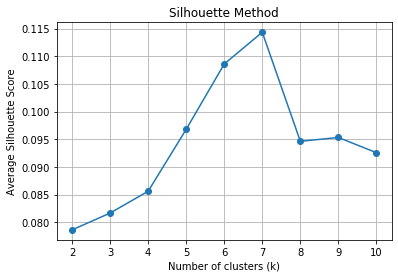

Optimal number of clusters (k): 7


In [74]:
max_k = 10  # Maximum number of clusters to consider
optimal_k = find_optimal_k_silhouette(minlm_embeddings, max_k)
print(f"Optimal number of clusters (k): {optimal_k}")

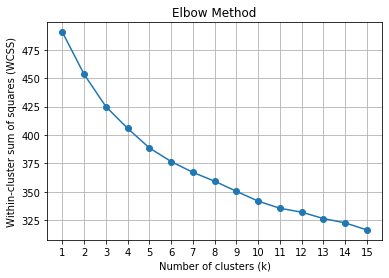

Optimal number of clusters (k): 3


In [75]:
# Example usage

max_k = 15  # Maximum number of clusters to consider
optimal_k = find_optimal_k(minlm_embeddings, max_k)
print(f"Optimal number of clusters (k): {optimal_k}")

C:\Users\anant\Anaconda3\lib\site-packages\hdbscan\plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


Optimal number of clusters (k): 48


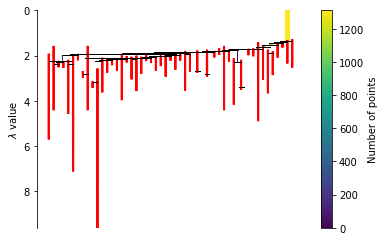

In [76]:
optimal_k = find_optimal_k_hdbscan(minlm_embeddings)
print(f"Optimal number of clusters (k): {optimal_k}")
plt.show()

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import numpy as np

# Define the autoencoder network architecture
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, latent_dim)
        )
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# Define the DEC model
class DEC(nn.Module):
    def __init__(self, input_dim, latent_dim, n_clusters):
        super(DEC, self).__init__()
        self.autoencoder = AutoEncoder(input_dim, latent_dim)
        self.cluster_centers = nn.Parameter(torch.Tensor(n_clusters, latent_dim))
        self.alpha = 1.0
        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.xavier_normal_(self.cluster_centers.data)

    def forward(self, x):
        latent, reconstructed = self.autoencoder(x)
        q = 1.0 / (1.0 + torch.sum((latent.unsqueeze(1) - self.cluster_centers) ** 2, dim=2) / self.alpha)
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = q / torch.sum(q, dim=1, keepdim=True)
        return latent, reconstructed, q

# Target distribution calculation
def target_distribution(q):
    weight = q ** 2 / torch.sum(q, dim=0)
    return (weight.t() / torch.sum(weight, dim=1)).t()

# Load embeddings (Assuming you have a list of embeddings)
minlm_embeddings = torch.Tensor(minlm_embeddings)

# Define model parameters
input_dim = minlm_embeddings.shape[1]
latent_dim = 10  # Latent space dimension
n_clusters = 7  # Number of clusters

# Instantiate DEC model
dec = DEC(input_dim, latent_dim, n_clusters)

# Pretrain autoencoder (optional but recommended)
pretrain_epochs = 10
pretrain_optimizer = optim.Adam(dec.autoencoder.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

for epoch in range(pretrain_epochs):
    latent, reconstructed = dec.autoencoder(minlm_embeddings)
    loss = loss_function(reconstructed, minlm_embeddings)
    pretrain_optimizer.zero_grad()
    loss.backward()
    pretrain_optimizer.step()
    print(f"Pretrain Epoch {epoch + 1}/{pretrain_epochs}, Loss: {loss.item()}")

# Initialize cluster centers using KMeans
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
latent, _ = dec.autoencoder(minlm_embeddings)
kmeans.fit(latent.detach().numpy())
dec.cluster_centers.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float)

# Train DEC model
dec_epochs = 100
dec_optimizer = optim.Adam(dec.parameters(), lr=1e-3)

for epoch in range(dec_epochs):
    latent, reconstructed, q = dec(minlm_embeddings)
    p = target_distribution(q).detach()
    kl_loss = nn.KLDivLoss(reduction='batchmean')(q.log(), p)
    reconst_loss = loss_function(reconstructed, minlm_embeddings)
    loss = reconst_loss + kl_loss
    dec_optimizer.zero_grad()
    loss.backward()
    dec_optimizer.step()
    print(f"DEC Epoch {epoch + 1}/{dec_epochs}, Total Loss: {loss.item()}, Reconstruction Loss: {reconst_loss.item()}, KL Loss: {kl_loss.item()}")

# Assign clusters to embeddings
latent, _, q = dec(minlm_embeddings)
cluster_assignments = torch.argmax(q, dim=1).numpy()




Pretrain Epoch 1/10, Loss: 0.0035647093318402767
Pretrain Epoch 2/10, Loss: 0.0024420013651251793
Pretrain Epoch 3/10, Loss: 0.0017351044807583094
Pretrain Epoch 4/10, Loss: 0.0013524139067158103
Pretrain Epoch 5/10, Loss: 0.0011697820154950023
Pretrain Epoch 6/10, Loss: 0.0011186901247128844
Pretrain Epoch 7/10, Loss: 0.0011068085441365838
Pretrain Epoch 8/10, Loss: 0.0011008940637111664
Pretrain Epoch 9/10, Loss: 0.0010897662723436952
Pretrain Epoch 10/10, Loss: 0.001068453653715551
DEC Epoch 1/100, Total Loss: 0.0010526549303904176, Reconstruction Loss: 0.0010526487603783607, KL Loss: 6.137778285619788e-09
DEC Epoch 2/100, Total Loss: 0.0014791374560445547, Reconstruction Loss: 0.0014791396679356694, KL Loss: -2.182320990584685e-09
DEC Epoch 3/100, Total Loss: 0.001241503283381462, Reconstruction Loss: 0.0012414967641234398, KL Loss: 6.524230933280251e-09
DEC Epoch 4/100, Total Loss: 0.0011604500468820333, Reconstruction Loss: 0.0011604370083659887, KL Loss: 1.3002996901434472e-08
D

DEC Epoch 62/100, Total Loss: 0.021302759647369385, Reconstruction Loss: 0.0009255473269149661, KL Loss: 0.02037721313536167
DEC Epoch 63/100, Total Loss: 0.02207127958536148, Reconstruction Loss: 0.0009233304299414158, KL Loss: 0.021147949621081352
DEC Epoch 64/100, Total Loss: 0.022906910628080368, Reconstruction Loss: 0.0009222251828759909, KL Loss: 0.021984685212373734
DEC Epoch 65/100, Total Loss: 0.02371383085846901, Reconstruction Loss: 0.0009227090049535036, KL Loss: 0.022791121155023575
DEC Epoch 66/100, Total Loss: 0.02450219728052616, Reconstruction Loss: 0.0009226468973793089, KL Loss: 0.0235795509070158
DEC Epoch 67/100, Total Loss: 0.025295983999967575, Reconstruction Loss: 0.0009197634062729776, KL Loss: 0.024376221001148224
DEC Epoch 68/100, Total Loss: 0.026190806180238724, Reconstruction Loss: 0.0009230747818946838, KL Loss: 0.02526773139834404
DEC Epoch 69/100, Total Loss: 0.026991602033376694, Reconstruction Loss: 0.0009180770139209926, KL Loss: 0.026073524728417397

In [83]:
# Add cluster labels to the DataFrame (assuming df is your DataFrame)
all_job_descriptions['Cluster_Labels_dec'] = cluster_assignments

In [84]:
all_job_descriptions.head()

,Job Description,R_word_count,R_char_count,R_word_density,R_punc_count,Job Description - Cleaned,Embeddings,Cluster_Labels,minlm_Embeddings,Cluster_Labels_dec
0,Booking.com\r It wasn’t so long ago that booki...,962,5781,0.166378,161,booking.com long ago book trip see eiffel towe...,"[-0.31907162, -1.0946442, -1.1768286, 0.832329...",-1,"[0.046670225, -0.059049662, 0.019969849, 0.001...",6
1,"At Booking.com, data drives our decisions. Tec...",687,3788,0.181314,77,booking.com data drive decision technology cor...,"[0.3812197, 0.23948741, 0.10944364, 0.07269724...",-1,"[0.02406419, -0.119199775, 0.0038206242, 0.035...",6
2,Booking.com’s global treasury team is looking ...,833,5243,0.158848,106,booking.com global treasury team look treasury...,"[0.06302524, 0.6085494, -0.30382383, 0.4328197...",-1,"[0.031354405, -0.036913585, -0.054946493, 0.00...",2
3,About the company\r It wasn’t so long ago that...,1155,6597,0.175053,116,company long ago book trip see eiffel tower st...,"[-1.0455714, -0.017056238, -1.1916978, 0.08443...",-1,"[0.036484517, -0.04959754, 0.0457783, 0.038244...",6
4,Account Executive - Bristol\r This is a full t...,549,2959,0.185473,53,account executive bristol full time position b...,"[0.058723077, 0.35270283, -0.7350738, 0.734504...",27,"[0.03586222, -0.08972985, 0.043199636, 0.00207...",2


In [85]:
all_job_descriptions['Cluster_Labels_dec'].value_counts()

6    697
2    614
Name: Cluster_Labels_dec, dtype: int64